try to find a set of '3D sensative' molecules, for example, based on how many conformers are generated when doing conformer generation with pruning

In [2]:
from rdkit import Chem
import gzip
from rdkit.Chem import rdDistGeom
import pickle
import rdkit
import os
print(f'RDKit version: {rdkit.__version__}')


import time
numConfs=100
def generate_confs(smiles):
    etkdg = rdDistGeom.ETKDGv3()
    etkdg.randomSeed = 0xa700f
    etkdg.verbose = False
    etkdg.numThreads = 4
    etkdg.trackFailures = True
    etkdg.useRandomCoords = True
    etkdg.pruneRmsThresh = 0.1
    confs_generated = []

    for smi in smiles:
        m = Chem.MolFromSmiles(smi)
        if m is None:
            print(f'Failed to create mol from SMILES: {smi}')
            continue
        m = Chem.AddHs(m)
        try:
            rdDistGeom.EmbedMultipleConfs(m,numConfs = numConfs, params = etkdg)
        except:
            print(f'Failed to generate conformers for SMILES: {smi}')
            continue
        confs_generated.append(m.GetNumConformers())
    return confs_generated

RDKit version: 2023.03.3


In [3]:
import pandas as pd
if not os.path.exists('OPERA_Naef_Training_incl_num_confs.csv'):
    df = pd.read_csv('OPERA_Naef_Training.csv')
    molblocks = df['molblock'].tolist()
    mols = [Chem.MolFromMolBlock(mb) for mb in molblocks]
    smiles = [Chem.MolToSmiles(m) for m in mols]

    start = time.time()
    confs_generated = generate_confs(smiles)
    end = time.time()
    print(confs_generated)
    #add the number of conformers to the dataframe
    df['confs'] = confs_generated
    df.to_csv('OPERA_Naef_Training_incl_num_confs.csv', index=False)
    #save the results
    data = {'smiles':smiles, 'confs_generated':confs_generated,'molblocks':molblocks}
    with open('confs_generated.pkl', 'wb') as f:
        pickle.dump(data, f)
    molregnos = df['molregno'].tolist()
    print(len(molregnos),len(confs_generated))
    #make dict molregno:confs
    molregno_confs = dict(zip(molregnos, confs_generated))
    with open('molregno_confs.pkl', 'wb') as f:
        pickle.dump(molregno_confs, f)
        


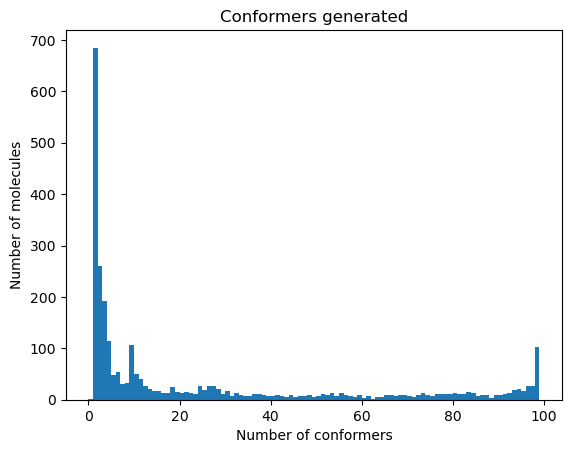

In [4]:
#histogram
#load data
import pickle
with open('confs_generated.pkl', 'rb') as f:
    data = pickle.load(f)
smiles = data['smiles']
confs_generated = data['confs_generated']
import matplotlib.pyplot as plt
plt.hist(confs_generated, bins=range(0, 100, 1))
plt.title('Conformers generated')
plt.xlabel('Number of conformers')
plt.ylabel('Number of molecules')
plt.show()

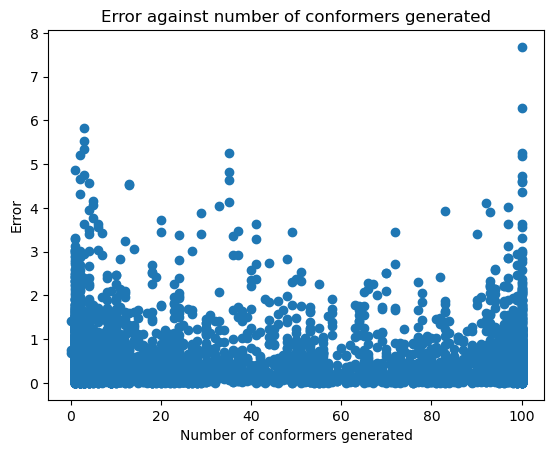

In [5]:
#load data_xgboost_physchem
import pandas as pd
molregno_confs = pickle.load(open('molregno_confs.pkl', 'rb'))
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/predictions/OPERA_Naef_XGBoost_PhysChem.pkl', 'rb') as f:
    data_xgboost_physchem = pickle.load(f)
pred_list_xgboost_physchem = data_xgboost_physchem['pred_list']
ys_list_xgboost_physchem = data_xgboost_physchem['ys_list']
molregnos_xgboost_physchem = data_xgboost_physchem['molregnos']
#make flat
pred_list_xgboost_physchem = [item for sublist in pred_list_xgboost_physchem for item in sublist]
ys_list_xgboost_physchem = [item for sublist in ys_list_xgboost_physchem for item in sublist]
molregnos_xgboost_physchem = [item for sublist in molregnos_xgboost_physchem for item in sublist]
#make df
df_xgboost_physchem = pd.DataFrame({'molregno':molregnos_xgboost_physchem, 'pred':pred_list_xgboost_physchem, 'ys':ys_list_xgboost_physchem})
df_xgboost_physchem
confs_xgboost_physchem = [molregno_confs[molregno] for molregno in molregnos_xgboost_physchem]
df_xgboost_physchem['confs_generated'] = confs_xgboost_physchem
df_xgboost_physchem
#add error
df_xgboost_physchem['Absolute error'] = abs(df_xgboost_physchem['ys'] - df_xgboost_physchem['pred'])
#plot error against number of conformers generated
plt.scatter(df_xgboost_physchem['confs_generated'], df_xgboost_physchem['Absolute error'])
plt.xlabel('Number of conformers generated')
plt.ylabel('Error')
plt.title('Error against number of conformers generated')
plt.show()

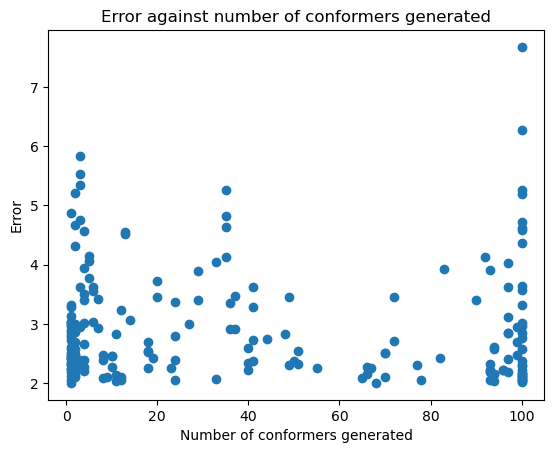

In [6]:
#zoom on error > 2
df_xgboost_physchem_zoom = df_xgboost_physchem[df_xgboost_physchem['Absolute error'] > 2]
plt.scatter(df_xgboost_physchem_zoom['confs_generated'], df_xgboost_physchem_zoom['Absolute error'])
plt.xlabel('Number of conformers generated')
plt.ylabel('Error')
plt.title('Error against number of conformers generated')
plt.show()

In [7]:
#add confs to df
confs_xgboost_physchem = [molregno_confs[molregno] for molregno in molregnos_xgboost_physchem]
df_xgboost_physchem['confs_generated'] = confs_xgboost_physchem
df_xgboost_physchem

,molregno,pred,ys,confs_generated,Absolute error
0,3265,3.899125,3.857102,9,0.042024
1,2404,-3.187017,-0.962598,96,2.224419
2,766,0.105732,0.271002,1,0.165270
3,75,3.637582,3.931102,11,0.293521
4,656,-2.213919,-2.212298,100,0.001621
...,...,...,...,...,...
6035,3406,3.560667,3.500801,1,0.059866
6036,607,3.460873,3.487001,3,0.026128
6037,2811,3.809885,3.454202,9,0.355683
6038,765,-5.615860,-5.600899,92,0.014961


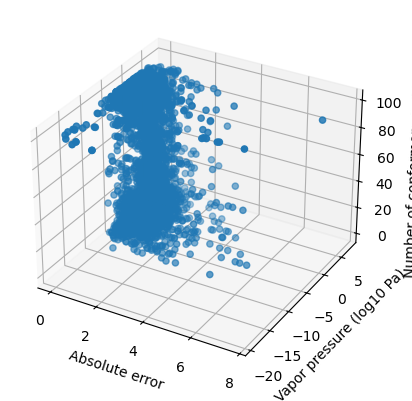

In [8]:
#can we do a 3D plot? ys, confs_generated, abs error
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_xgboost_physchem['Absolute error'], df_xgboost_physchem['ys'], df_xgboost_physchem['confs_generated'])
ax.set_xlabel('Absolute error')
ax.set_ylabel('Vapor pressure (log10 Pa)')
ax.set_zlabel('Number of conformers generated')
plt.show()

In [9]:
#normality test for all three
from scipy.stats import shapiro
print(shapiro(df_xgboost_physchem['Absolute error']))
print(shapiro(df_xgboost_physchem['ys']))
print(shapiro(df_xgboost_physchem['confs_generated']))
#print the kendall tau between ys and absoulte error, and confs and absolute error, and confs and ys
from scipy.stats import kendalltau
print(kendalltau(df_xgboost_physchem['ys'], df_xgboost_physchem['Absolute error']))
print(kendalltau(df_xgboost_physchem['confs_generated'], df_xgboost_physchem['Absolute error']))
print(kendalltau(df_xgboost_physchem['ys'], df_xgboost_physchem['confs_generated']))

ShapiroResult(statistic=0.6743950843811035, pvalue=0.0)
ShapiroResult(statistic=0.9472267031669617, pvalue=4.572436889091878e-42)
ShapiroResult(statistic=0.7453516721725464, pvalue=0.0)
SignificanceResult(statistic=-0.23730051689106366, pvalue=2.7829368452813836e-168)
SignificanceResult(statistic=0.04764771640651515, pvalue=8.150721683454962e-08)
SignificanceResult(statistic=-0.10948319854325858, pvalue=6.877662496857381e-35)


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


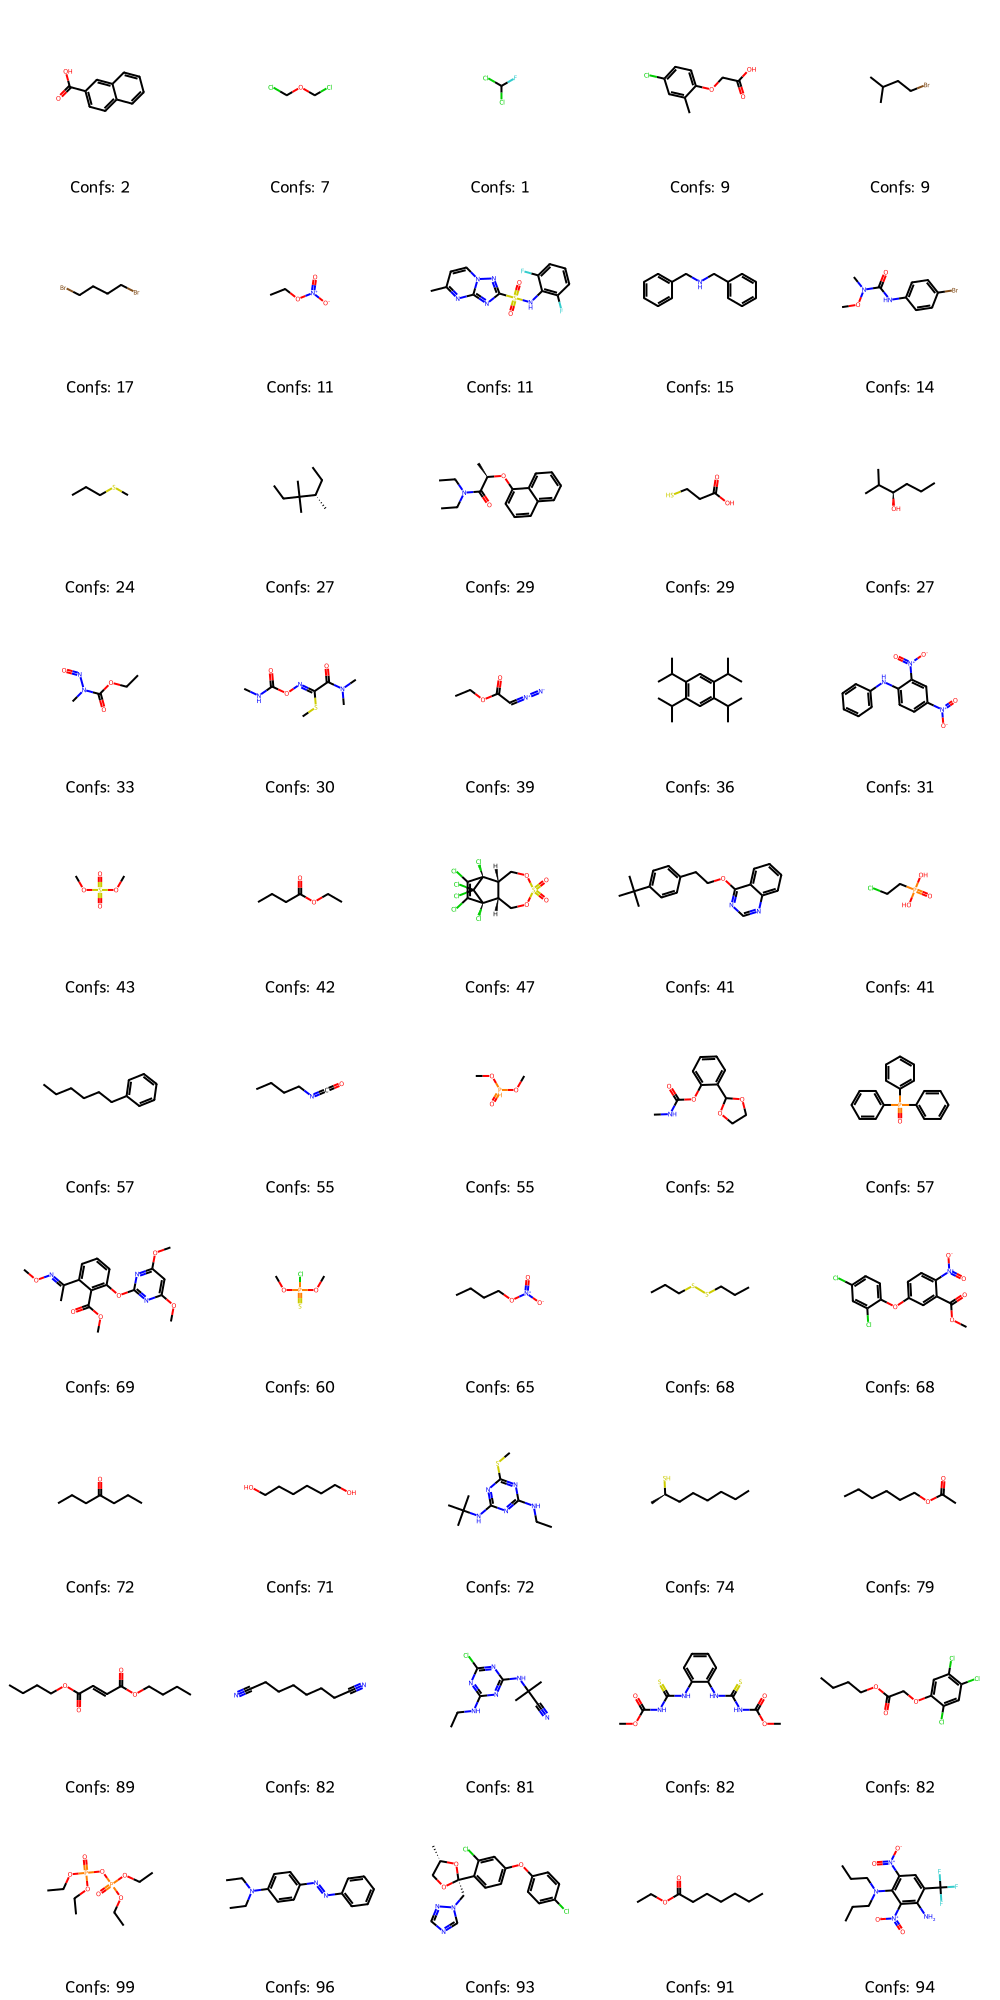

In [10]:
#lets also get a bit of an idea about what these molecules look like. From each bin (0-10, 10-20, 20-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-90, 90-100) we will take 5 molecules and visualize them
import numpy as np
df = pd.read_csv('OPERA_Naef_Training_incl_num_confs.csv')
bins = np.linspace(0, 100, 11)
df['bin'] = np.digitize(df['confs'], bins)
mols = []
for i in range(1,11):
    df_bin = df[df['bin'] == i]
    mols_bin = df_bin['molregno'].tolist()
    mols_bin = mols_bin[:5]
    mols.extend(mols_bin)
df_sampled = df[df['molregno'].isin(mols)]
#sort by bin
df_sampled = df_sampled.sort_values(by='bin')
molblocks = df_sampled['molblock'].tolist()
num_confs_list = df_sampled['confs'].tolist()
from rdkit.Chem import Draw
from rdkit import Chem
mols = [Chem.MolFromMolBlock(mb) for mb in molblocks]
mols_2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in mols]  
img = Draw.MolsToGridImage(mols_2d, molsPerRow=5, subImgSize=(200,200), legends=[f'Confs: {num_confs_list[i]}' for i in range(len(mols))])
img

confs
1      685
100    278
2      260
3      192
4      115
      ... 
49       5
88       4
60       3
62       2
0        2
Name: count, Length: 101, dtype: int64


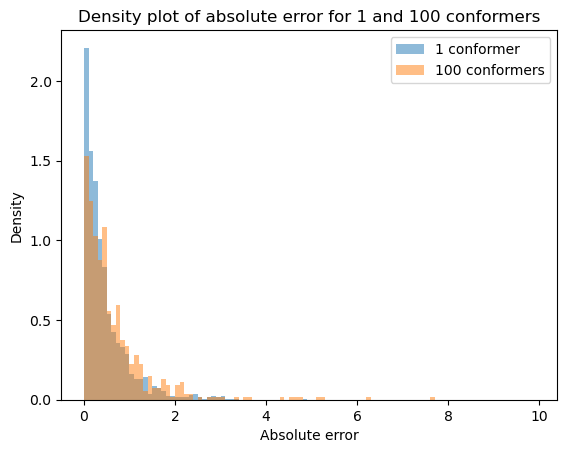

KstestResult(statistic=0.15879409769335143, pvalue=5.118005358579461e-09, statistic_location=0.3491660944314696, statistic_sign=1)


In [11]:
#count: how many with 100, how many with 1
print(df['confs'].value_counts())
#get distribution of of errors for confs = 1 and confs = 100
df_1 = df[df['confs'] == 1]
df_100 = df[df['confs'] == 100]
molregnos_1 = df_1['molregno'].tolist()
molregnos_100 = df_100['molregno'].tolist()
df_xgboost_physchem_1 = df_xgboost_physchem[df_xgboost_physchem['molregno'].isin(molregnos_1)]
df_xgboost_physchem_100 = df_xgboost_physchem[df_xgboost_physchem['molregno'].isin(molregnos_100)]
#plot histogram density plot of Absolute error of thes two
import seaborn as sns
plt.hist(df_xgboost_physchem_1['Absolute error'], bins=[x / 10 for x in range(0, 100,1)], density=True, alpha=0.5, label='1 conformer')
plt.hist(df_xgboost_physchem_100['Absolute error'], bins=[x / 10 for x in range(0, 100,1)], density=True, alpha=0.5, label='100 conformers')
plt.legend()
plt.xlabel('Absolute error')
plt.ylabel('Density')
plt.title('Density plot of absolute error for 1 and 100 conformers')
plt.show()

#are these two statistically different? use ks test
from scipy.stats import ks_2samp
print(ks_2samp(df_xgboost_physchem_1['Absolute error'], df_xgboost_physchem_100['Absolute error']))


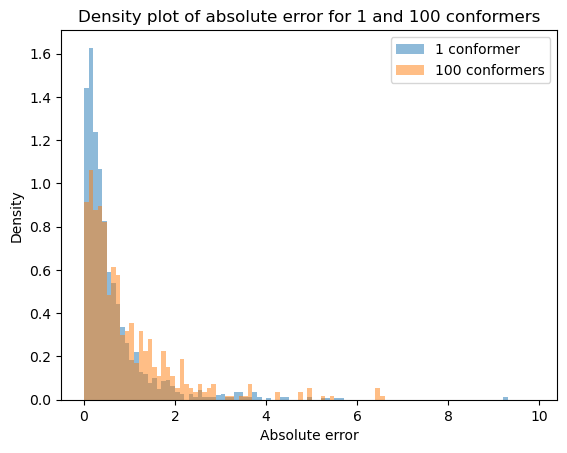

KstestResult(statistic=0.17932708616010856, pvalue=2.1770065625340738e-11, statistic_location=0.6147428768069538, statistic_sign=1)


In [12]:
#repeath for mdfp
import pickle
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/splits/predictions/OPERA_Naef_XGBoost_MDFP.pkl', 'rb') as f:
    data_mdfp = pickle.load(f)
pred_list_mdfp = data_mdfp['pred_list']
ys_list_mdfp = data_mdfp['ys_list']
molregnos_mdfp = data_mdfp['molregnos']
#make flat
pred_list_mdfp = [item for sublist in pred_list_mdfp for item in sublist]
ys_list_mdfp = [item for sublist in ys_list_mdfp for item in sublist]
molregnos_mdfp = [item for sublist in molregnos_mdfp for item in sublist]
#make df
df_mdfp = pd.DataFrame({'molregno':molregnos_mdfp, 'pred':pred_list_mdfp, 'ys':ys_list_mdfp})
df_mdfp
confs_mdfp = [molregno_confs[molregno] for molregno in molregnos_mdfp]
df_mdfp['confs_generated'] = confs_mdfp
df_mdfp
#add error
df_mdfp['Absolute error'] = abs(df_mdfp['ys'] - df_mdfp['pred'])
df_mdfp_1 = df_mdfp[df_mdfp['molregno'].isin(molregnos_1)]
df_mdfp_100 = df_mdfp[df_mdfp['molregno'].isin(molregnos_100)]
#plot histogram density plot of Absolute error of thes two
import seaborn as sns
plt.hist(df_mdfp_1['Absolute error'], bins=[x / 10 for x in range(0, 100,1)], density=True, alpha=0.5, label='1 conformer')
plt.hist(df_mdfp_100['Absolute error'], bins=[x / 10 for x in range(0, 100,1)], density=True, alpha=0.5, label='100 conformers')
plt.legend()
plt.xlabel('Absolute error')
plt.ylabel('Density')
plt.title('Density plot of absolute error for 1 and 100 conformers')
plt.show()

#are these two statistically different? use ks test
from scipy.stats import ks_2samp
print(ks_2samp(df_mdfp_1['Absolute error'], df_mdfp_100['Absolute error']))

mean errors
confs_bins
1       0.453469
2-99    0.467587
100     0.664504
Name: Absolute error, dtype: float64
median errors
confs_bins
1       0.288426
2-99    0.257628
100     0.430268
Name: Absolute error, dtype: float64
mean ys
confs_bins
1       0.623247
2-99    0.825485
100    -2.645991
Name: ys, dtype: float64
median ys
confs_bins
1       1.337952
2-99    1.516000
100    -2.154398
Name: ys, dtype: float64


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/tmp/ipykernel_2723269/1607765012.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_xgboost_physchem.groupby('confs_bins')['Absolute

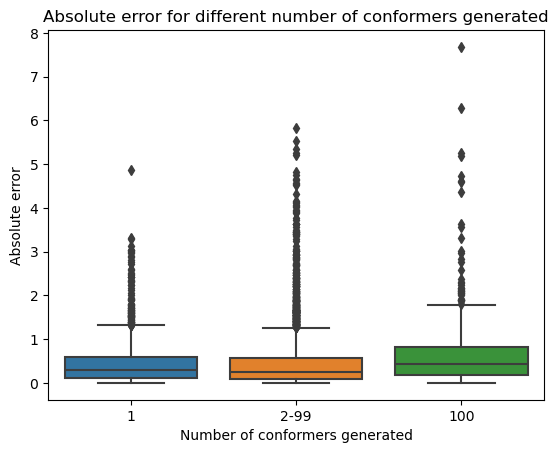

In [13]:
df_xgboost_physchem
#creat bins for confs_generated; 1, 2-99, 100
df_xgboost_physchem['confs_bins'] = pd.cut(df_xgboost_physchem['confs_generated'], bins=[0,1,99,100], labels=['1', '2-99', '100'])
df_xgboost_physchem['confs_bins'].value_counts()
#plot absolute error for these bins
import seaborn as sns
sns.boxplot(x='confs_bins', y='Absolute error', data=df_xgboost_physchem)
plt.xlabel('Number of conformers generated')
plt.ylabel('Absolute error')
plt.title('Absolute error for different number of conformers generated')
#print the mean and medians of absolute error for these bins
print('mean errors')
print(df_xgboost_physchem.groupby('confs_bins')['Absolute error'].mean())
print('median errors')
print(df_xgboost_physchem.groupby('confs_bins')['Absolute error'].median())
#now also the mean and median of the ys
print('mean ys')
print(df_xgboost_physchem.groupby('confs_bins')['ys'].mean())
print('median ys')
print(df_xgboost_physchem.groupby('confs_bins')['ys'].median())

plt.show()

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/tmp/ipykernel_2723269/2815721911.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df_xgboost_physchem[df_xgboost_physchem['ys_bin

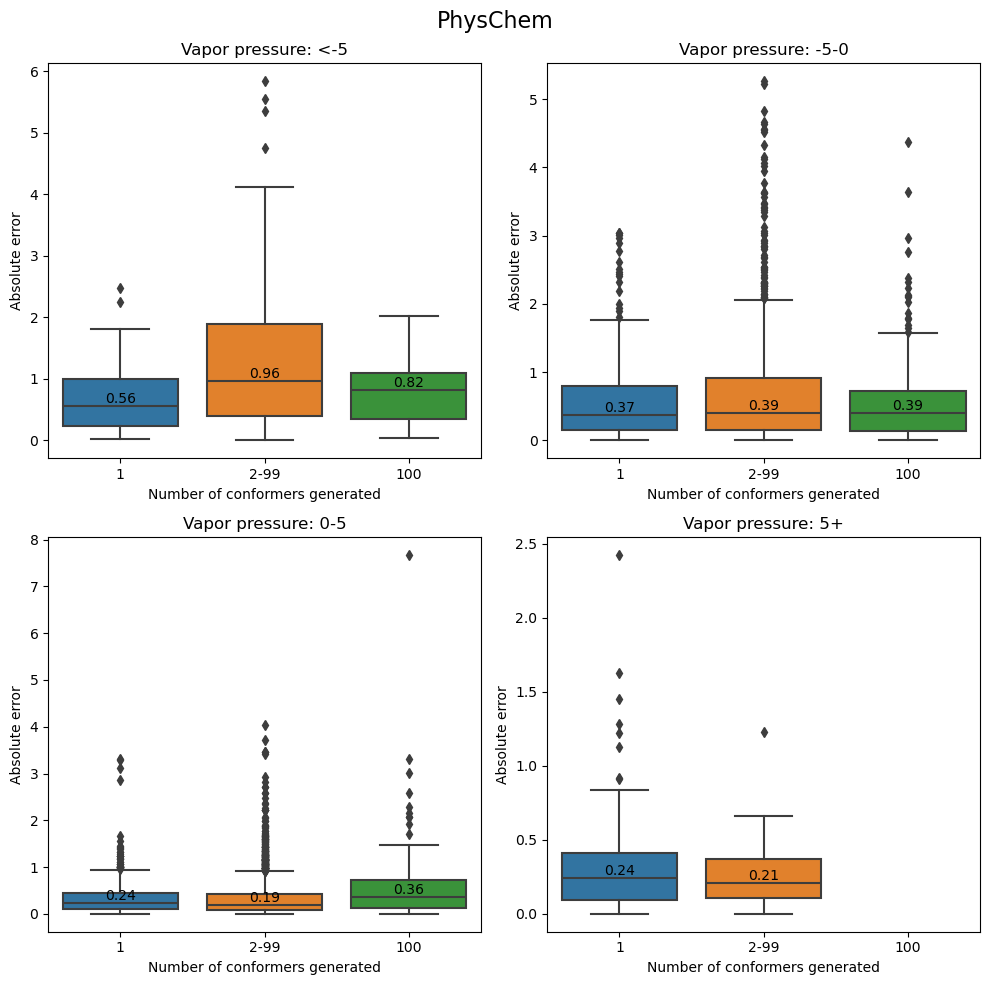

In [14]:
#now lets stratify the ys: <-5, -5 - 0, 0-5, 5+
df_xgboost_physchem['ys_bins'] = pd.cut(df_xgboost_physchem['ys'], bins=[-6, -5, 0, 5, 100], labels=['<-5', '-5-0', '0-5', '5+'])
#now lets do the same as before, but stratified by ys. so 4 subplots of boxplots
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(x='confs_bins', y='Absolute error', data=df_xgboost_physchem[df_xgboost_physchem['ys_bins'] == df_xgboost_physchem['ys_bins'].cat.categories[i]], ax=ax)
    ax.set_title(f'Vapor pressure: {df_xgboost_physchem["ys_bins"].cat.categories[i]}')
    ax.set_xlabel('Number of conformers generated')
    ax.set_ylabel('Absolute error')
    #add textbox with median for each boxplot
    medians = df_xgboost_physchem[df_xgboost_physchem['ys_bins'] == df_xgboost_physchem['ys_bins'].cat.categories[i]].groupby('confs_bins')['Absolute error'].median()
    for j, median in enumerate(medians):
        ax.text(j, median, f'{median:.2f}', ha='center', va='bottom')
plt.suptitle('PhysChem', fontsize=16)
plt.tight_layout()
plt.show()


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/tmp/ipykernel_2723269/473214802.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df_mdfp[df_mdfp['ys_bins'] == df_mdfp['ys_bins']

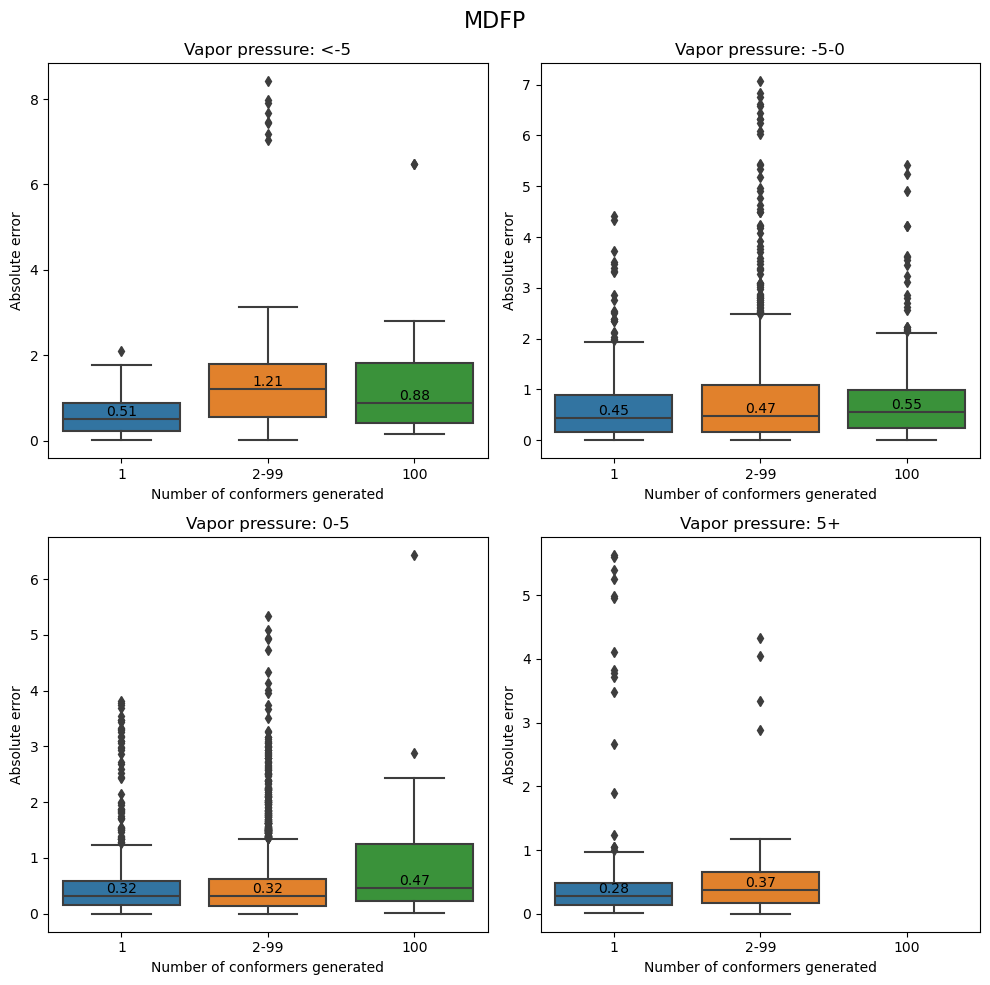

In [15]:
#same for mdfp
df_mdfp['confs_bins'] = pd.cut(df_mdfp['confs_generated'], bins=[0,1,99,100], labels=['1', '2-99', '100'])
df_mdfp['confs_bins'].value_counts()
df_mdfp['ys_bins'] = pd.cut(df_mdfp['ys'], bins=[-6, -5, 0, 5, 100], labels=['<-5', '-5-0', '0-5', '5+'])
#now lets do the same as before, but stratified by ys. so 4 subplots of boxplots
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(x='confs_bins', y='Absolute error', data=df_mdfp[df_mdfp['ys_bins'] == df_mdfp['ys_bins'].cat.categories[i]], ax=ax)
    ax.set_title(f'Vapor pressure: {df_mdfp["ys_bins"].cat.categories[i]}')
    ax.set_xlabel('Number of conformers generated')
    ax.set_ylabel('Absolute error')
    #add textbox with median for each boxplot
    medians = df_mdfp[df_mdfp['ys_bins'] == df_mdfp['ys_bins'].cat.categories[i]].groupby('confs_bins')['Absolute error'].median()
    for j, median in enumerate(medians):
        ax.text(j, median, f'{median:.2f}', ha='center', va='bottom')
plt.suptitle('MDFP', fontsize=16)
plt.tight_layout()
plt.show()


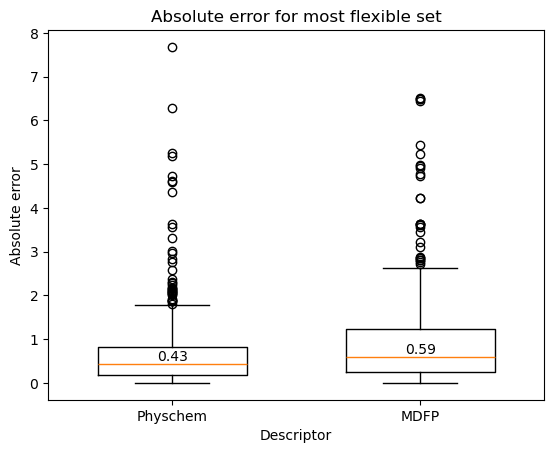

In [16]:
#and boxplot: for 100 confs, physchem vs mdfp
df_xgboost_physchem_100 = df_xgboost_physchem[df_xgboost_physchem['confs_bins'] == '100']
df_mdfp_100 = df_mdfp[df_mdfp['confs_bins'] == '100']
fig, ax = plt.subplots()
plt.boxplot(df_xgboost_physchem_100['Absolute error'], positions=[1], widths=0.6)
plt.boxplot(df_mdfp_100['Absolute error'], positions=[2], widths=0.6)
ax.set_xticks([1,2])
ax.set_xticklabels(['Physchem', 'MDFP'])
plt.xlabel('Descriptor')
plt.ylabel('Absolute error')
plt.title('Absolute error for most flexible set')
#add medians as text
median_physchem = df_xgboost_physchem_100['Absolute error'].median()
median_mdfp = df_mdfp_100['Absolute error'].median()
plt.text(1, median_physchem, f'{median_physchem:.2f}', ha='center', va='bottom')
plt.text(2, median_mdfp, f'{median_mdfp:.2f}', ha='center', va='bottom')
plt.show()

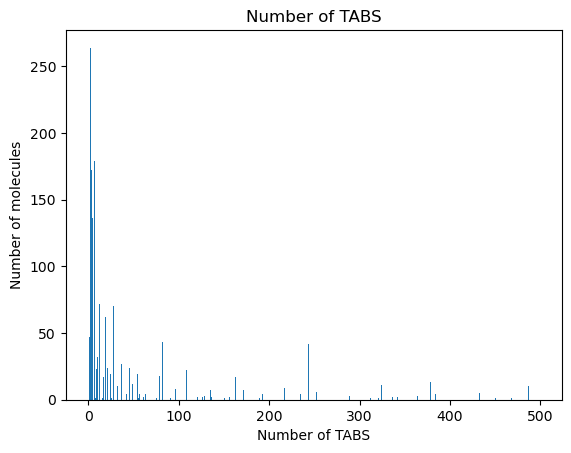

In [17]:
#TABS
#read in txt file nTABS.txt: first column is smiles, second is nTABS
import pandas as pd
df_tabs = pd.read_csv('nTABS.txt', sep=' ', header=None)
df_tabs.columns = ['smiles', 'nTABS']
df_tabs
#histogram
plt.hist(df_tabs['nTABS'], bins=range(0, 500, 1))
plt.title('Number of TABS')
plt.xlabel('Number of TABS')
plt.ylabel('Number of molecules')
plt.show()


Text(0.5, 1.0, 'Number of molecules with more than x TABS')

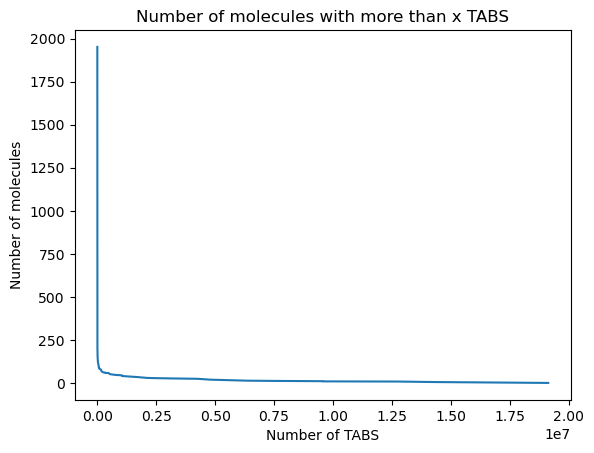

In [18]:
#sort by nTABS
df_tabs = df_tabs.sort_values(by='nTABS', ascending=False)
#do a line plot: aggregated number of molecules with nTABS > x
nTABS = df_tabs['nTABS'].tolist()
nTABS = list(set(nTABS))
nTABS = sorted(nTABS)
nTABS
nTABS_counts = []
for n in nTABS:
    nTABS_counts.append(len(df_tabs[df_tabs['nTABS'] > n]))
plt.plot(nTABS, nTABS_counts)
plt.xlabel('Number of TABS')
plt.ylabel('Number of molecules')
plt.title('Number of molecules with more than x TABS')


In [19]:
#divide into three bins: low, medium, high
#print min and max
print(df_tabs['nTABS'].min())
print(df_tabs['nTABS'].max())
df_tabs['nTABS_bins'] = pd.cut(df_tabs['nTABS'], bins=[0, 1, 10,100, 1000,2000000000], labels=['0', '1-10', '10-100', '100-1000', '1000+'])
df_tabs['nTABS_bins'].value_counts()

1
19131876


nTABS_bins
1-10        909
10-100      473
1000+       296
100-1000    274
0            47
Name: count, dtype: int64

In [20]:
len(df_tabs[df_tabs['nTABS'] == 1])

47

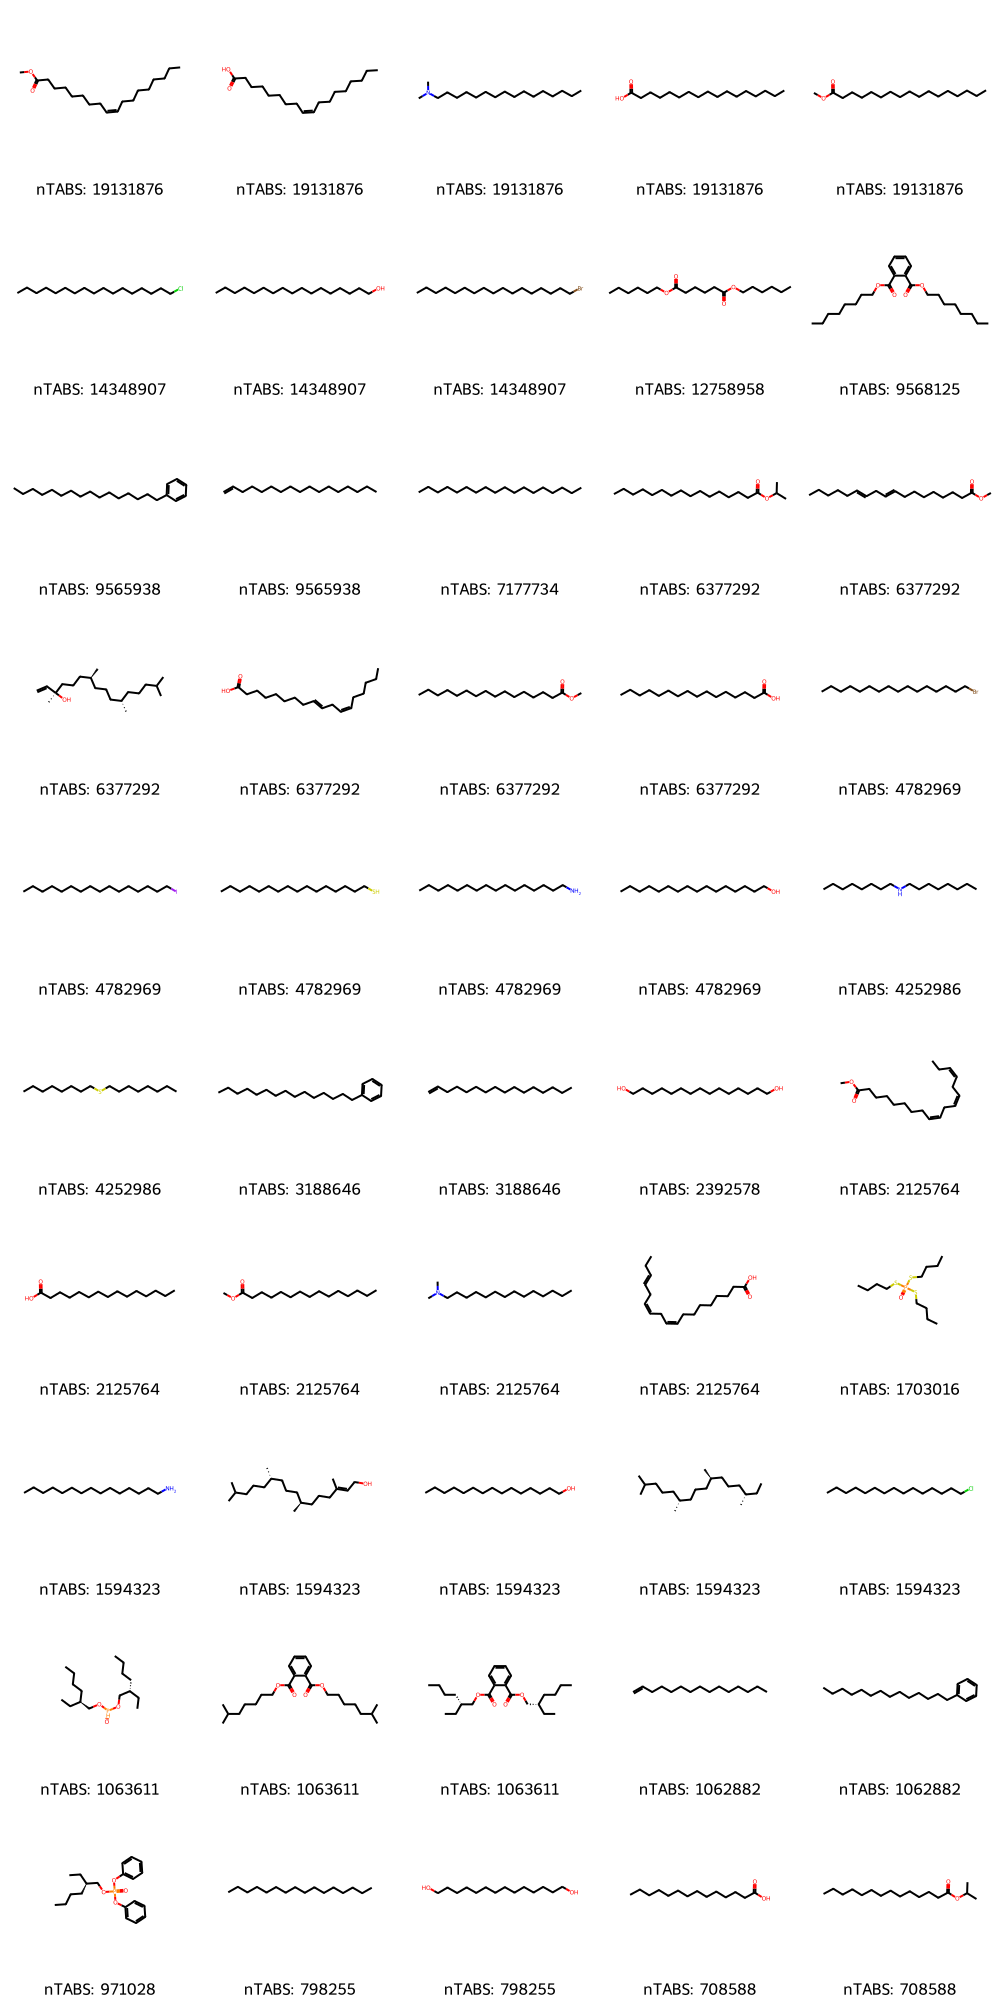

In [21]:
#draw the top 50 most flexible ones
from rdkit.Chem import Draw
from rdkit import Chem
smiles = df_tabs['smiles'].tolist()
smiles = smiles[:50]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200), legends=[f'nTABS: {df_tabs.iloc[i,1]}' for i in range(50)])
img

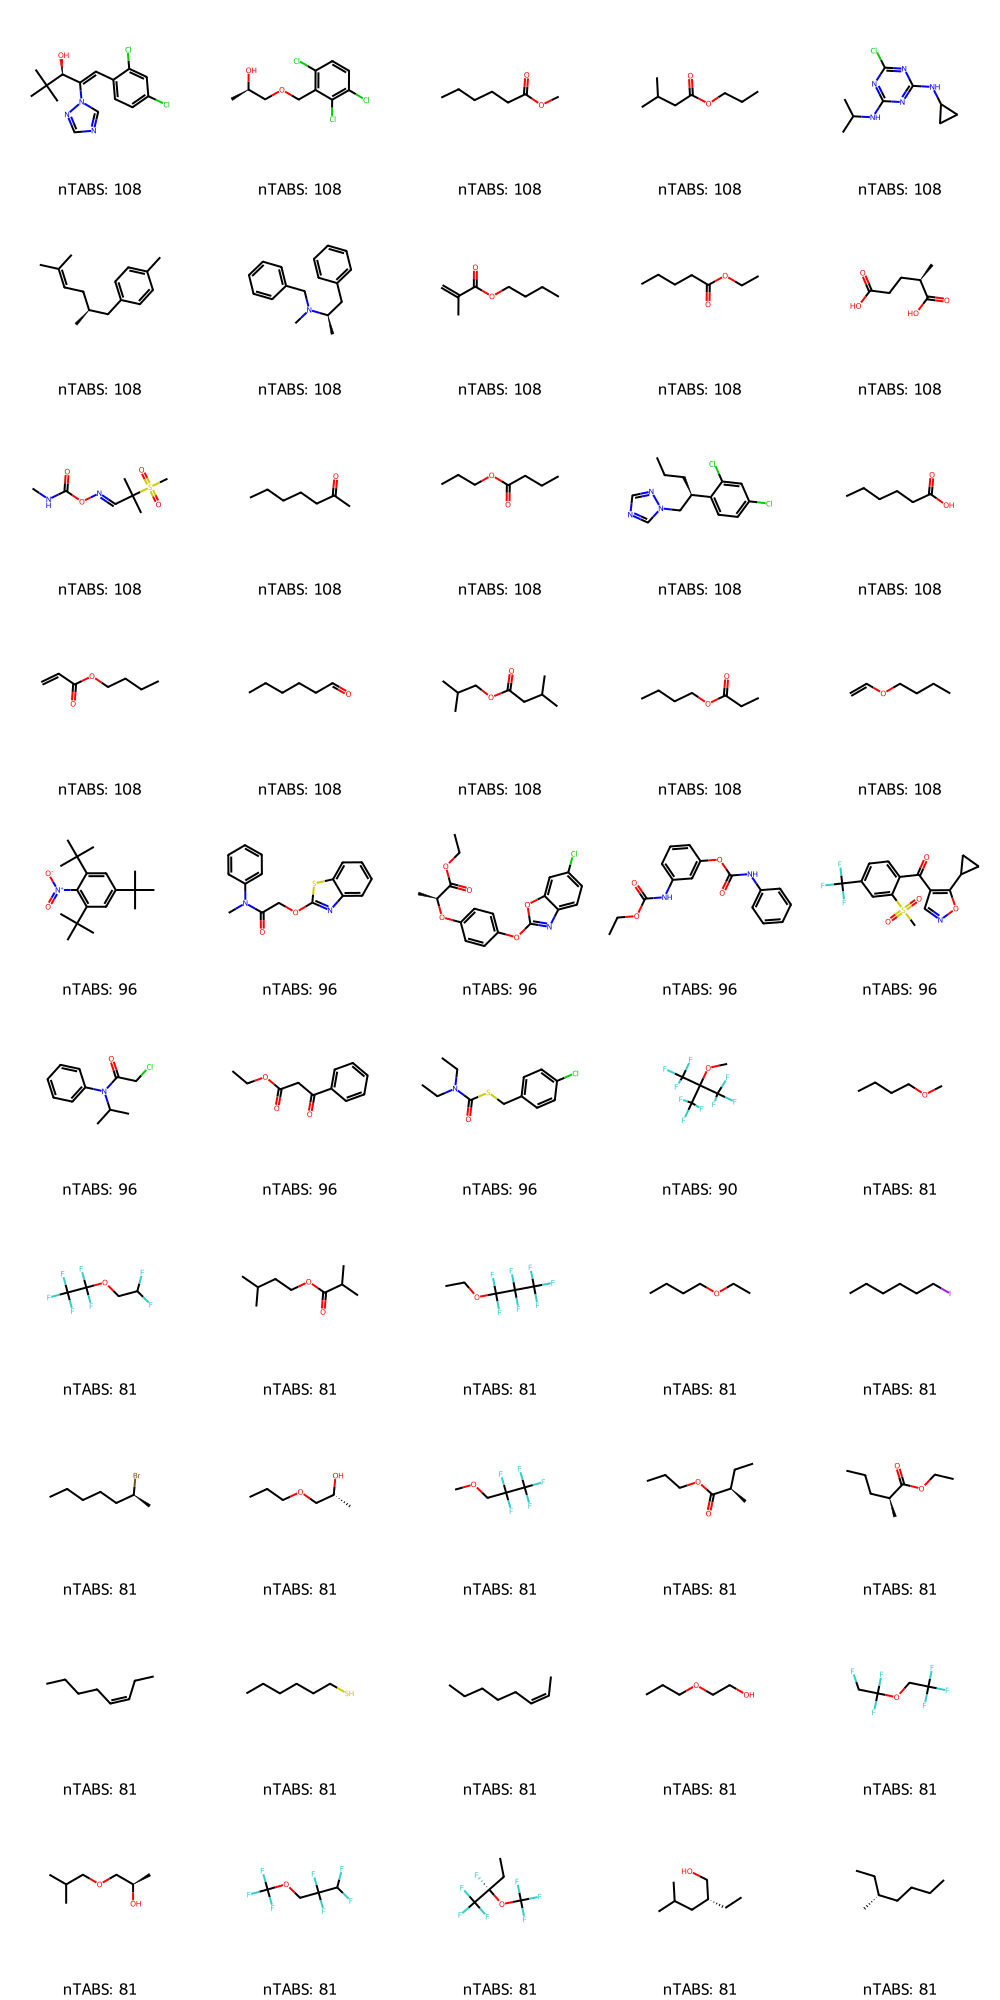

In [22]:
#also look at the 50:100
start = 550
end = 600
smiles = df_tabs['smiles'].tolist()
smiles = smiles[start:end]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200), legends=[f'nTABS: {df_tabs.iloc[i,1]}' for i in range(start,end)])
img

In [27]:
df_tabs
#get the molregnos for these smiles using lwreg
import lwreg
from lwreg import standardization_lib
from lwreg import utils
config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'lebanon'
config['user'] = 'cschiebroek'
config['password'] = '' # password is saved in our .pgpass
# we don't want to standardize the molecules:
config['standardization'] = standardization_lib.RemoveHs()
# we want to store conformers
config['registerConformers'] = True

In [42]:
smiles = df_tabs['smiles'].tolist()
molregnos = [lwreg.query(config=config, smiles=smi) for smi in smiles]


In [44]:
print(len(molregnos))
molregno_list = []
for i in molregnos:
    if len(i) > 0:
        molregno_list.append(i[0])
    else:
        molregno_list.append(None)
print(len(molregno_list))
df_tabs['molregno'] = molregno_list

1999
1999


In [47]:
df_xgboost_physchem
#drop confs_bin and ys_bin
df_xgboost_physchem = df_xgboost_physchem.drop(columns=['confs_bins', 'ys_bins'])

In [48]:
df_xgboost_physchem_avg = df_xgboost_physchem.groupby('molregno').mean()
df_xgboost_physchem_avg = df_xgboost_physchem_avg.reset_index()
#now merge with df_tabs
df_tabs_xgboost_physchem = df_tabs.merge(df_xgboost_physchem_avg, on='molregno', how='inner')
df_tabs_xgboost_physchem

,smiles,nTABS,nTABS_bins,molregno,pred,ys,confs_generated,Absolute error
0,CCCCCCCC/C=C\CCCCCCCC(=O)OC,19131876,1000+,2895.0,-2.817053,-3.076399,100.0,0.259346
1,CCCCCCCC/C=C\CCCCCCCC(=O)O,19131876,1000+,16746.0,-4.505755,-3.728998,100.0,0.776757
2,CCCCCCCCCCCCCCCCN(C)C,19131876,1000+,3209.0,-2.610699,-1.986000,100.0,0.624699
3,CCCCCCCCCCCCCCCCC(=O)O,19131876,1000+,225.0,-4.016470,-5.080598,100.0,1.064129
4,CCCCCCCCCCCCCCCCC(=O)OC,19131876,1000+,15791.0,-2.650908,-2.524000,100.0,0.252167
...,...,...,...,...,...,...,...,...
1750,CCO[Si](C)(C)C,1,0,16993.0,3.758364,4.184802,4.0,0.426438
1751,COc1ccccc1Cl,1,0,17025.0,2.174696,1.501502,1.0,0.673194
1752,CNC=O,1,0,4103.0,2.167209,1.546000,1.0,0.621209
1753,COc1ccccc1O,1,0,4132.0,0.653244,1.137701,1.0,0.484457


Kendall tau 0.801
Spearman 0.92


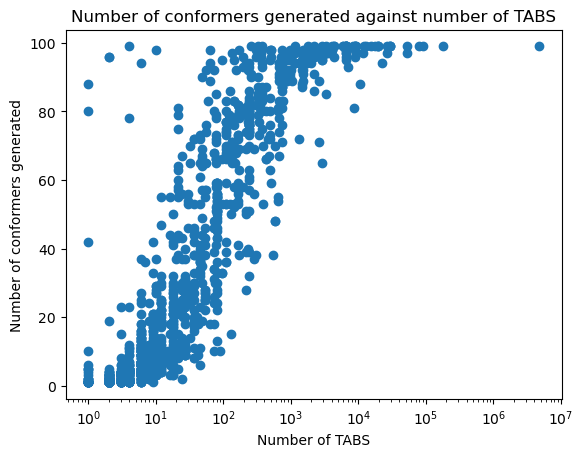

In [69]:
#plot ntabs against confs_generated
#make copy of df where number of conformers is not 100
df_tabs_xgboost_physchem_not100 = df_tabs_xgboost_physchem[df_tabs_xgboost_physchem['confs_generated'] < 100]
#print some correlation metrics: kendall tau, pearson, spearman
from scipy.stats import kendalltau
from scipy.stats import pearsonr
from scipy.stats import spearmanr
print('Kendall tau', round(kendalltau(df_tabs_xgboost_physchem_not100['nTABS'], df_tabs_xgboost_physchem_not100['confs_generated']).statistic, 3))
# print('Pearson', pearsonr(df_tabs_xgboost_physchem_not100['nTABS'], df_tabs_xgboost_physchem_not100['confs_generated']).statistic)
print('Spearman', round(spearmanr(df_tabs_xgboost_physchem_not100['nTABS'], df_tabs_xgboost_physchem_not100['confs_generated']).correlation, 3))
plt.scatter(df_tabs_xgboost_physchem_not100['nTABS'], df_tabs_xgboost_physchem_not100['confs_generated'])
plt.xlabel('Number of TABS')
plt.ylabel('Number of conformers generated')
plt.title('Number of conformers generated against number of TABS')
#x on log scale
plt.xscale('log')
plt.show()

In [1]:
df_tabs_xgboost_physchem_not100

NameError: name 'df_tabs_xgboost_physchem_not100' is not defined

/tmp/ipykernel_2723269/2139853593.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tabs_xgboost_physchem_not100['outlier'] = outliers


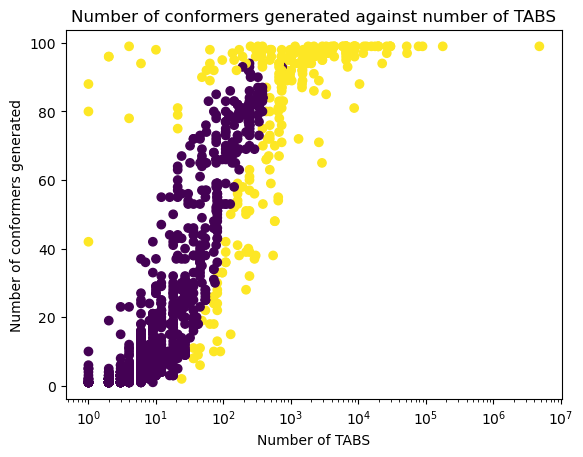

/tmp/ipykernel_2723269/2139853593.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tabs_xgboost_physchem_not100['outlier2'] = 0


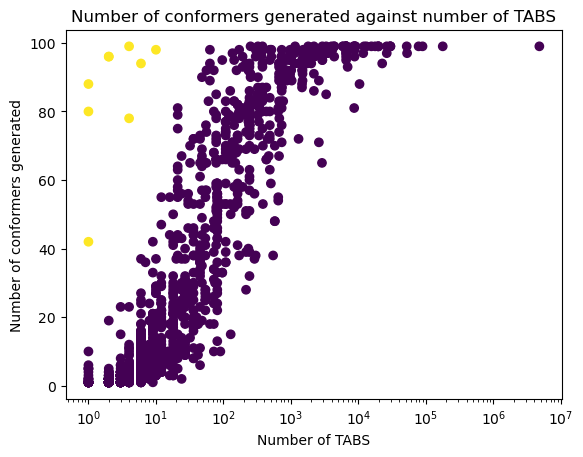

In [148]:
#get the outliers
#normalize both
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df_tabs_xgboost_physchem_not100[['nTABS', 'confs_generated']]
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=['nTABS', 'confs_generated'])
X
#find the outliers
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0)
clf.fit(X)
outliers = clf.predict(X)
outliers = [1 if i == -1 else 0 for i in outliers]
df_tabs_xgboost_physchem_not100['outlier'] = outliers
df_tabs_xgboost_physchem_not100['outlier'].value_counts()   
#plot the outliers
plt.scatter(df_tabs_xgboost_physchem_not100['nTABS'], df_tabs_xgboost_physchem_not100['confs_generated'], c=df_tabs_xgboost_physchem_not100['outlier'])
plt.xlabel('Number of TABS')
plt.ylabel('Number of conformers generated')
plt.title('Number of conformers generated against number of TABS')
#x on log scale
plt.xscale('log')
plt.show()
#get thhose with <100 nTABs and > 40 conformers
outliers_2 = df_tabs_xgboost_physchem_not100[(df_tabs_xgboost_physchem_not100['nTABS'] < 20) & (df_tabs_xgboost_physchem_not100['confs_generated'] > 40) & (df_tabs_xgboost_physchem_not100['outlier'] == 1)]
outliers_2
df_tabs_xgboost_physchem_not100['outlier2'] = 0
df_tabs_xgboost_physchem_not100.loc[df_tabs_xgboost_physchem_not100['molregno'].isin(outliers_2['molregno']), 'outlier2'] = 1
df_tabs_xgboost_physchem_not100['outlier2'].value_counts()
plt.scatter(df_tabs_xgboost_physchem_not100['nTABS'], df_tabs_xgboost_physchem_not100['confs_generated'], c=df_tabs_xgboost_physchem_not100['outlier2'])
plt.xlabel('Number of TABS')
plt.ylabel('Number of conformers generated')
plt.title('Number of conformers generated against number of TABS')
#x on log scale
plt.xscale('log')
plt.show()


CCCOB(OCCC)OCCC
CSP(C(F)(F)F)C(F)(F)F
CC(C)(C)SP(C(F)(F)F)C(F)(F)F
C=CP(C=C)C=C
C[Si](Cn1cncn1)(c1ccc(F)cc1)c1ccc(F)cc1
C=C[Si](OCC)(OCC)OCC
CCO[Si](C)(C)OCC
CCO[Si](OCC)(OCC)OCC
CC(C)OB(OC(C)C)OC(C)C


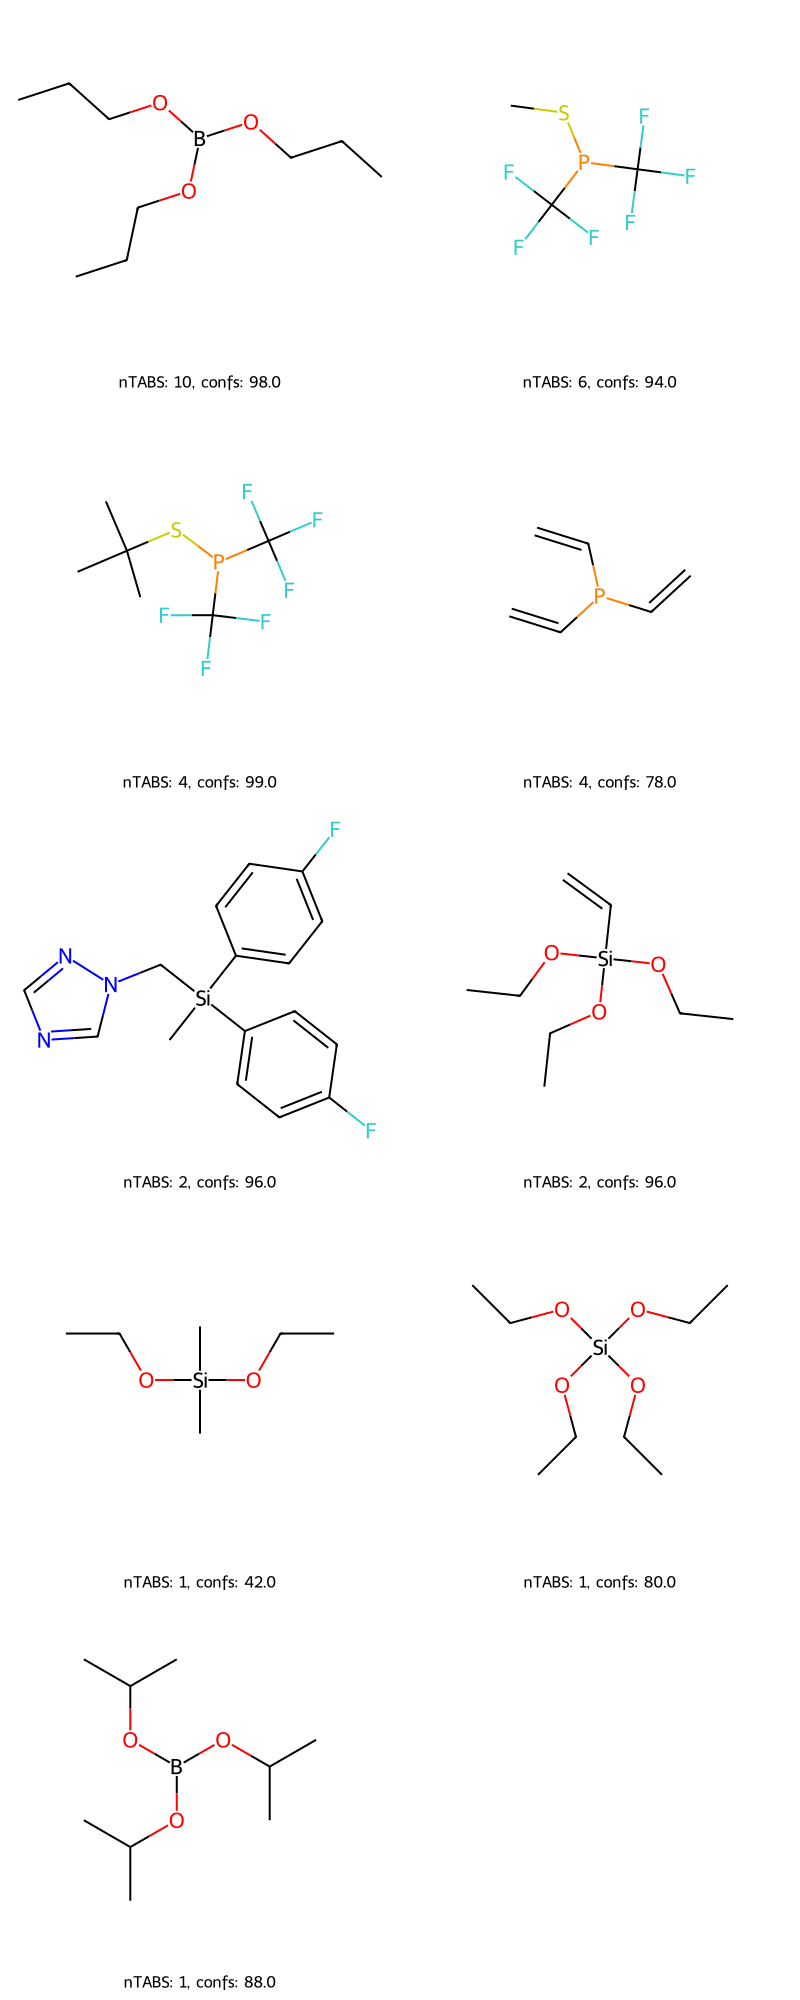

In [156]:
#get smiles for these outliers
smiles_outliers = df_tabs_xgboost_physchem_not100[df_tabs_xgboost_physchem_not100['outlier2'] == 1]['smiles'].tolist()
#for these, get the ntabs and confs
ntabs_list, confs_list = [], []
for smi in smiles_outliers:
    print(smi)
    ntabs_list.append(df_tabs_xgboost_physchem_not100[df_tabs_xgboost_physchem_not100['smiles'] == smi]['nTABS'].tolist()[0])
    confs_list.append(df_tabs_xgboost_physchem_not100[df_tabs_xgboost_physchem_not100['smiles'] == smi]['confs_generated'].tolist()[0])
#draw
from rdkit.Chem import Draw
from rdkit import Chem
mols = [Chem.MolFromSmiles(smi) for smi in smiles_outliers]
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400,400), legends=[f'nTABS: {ntabs_list[i]}, confs: {confs_list[i]}' for i in range(len(mols))])
img

In [154]:
df_tabs_xgboost_physchem_not100

,smiles,nTABS,nTABS_bins,molregno,pred,ys,confs_generated,Absolute error,log10nTABS,nrotb,outlier,outlier2
18,CCCCCCCCCCCCCCCCI,4782969,1000+,276.0,-1.979506,-2.657899,99.0,0.678393,6.679698,14,1,0
61,CCCCOCCOCCOCCO,177147,1000+,3817.0,-1.263933,-0.477198,99.0,0.786735,5.248334,11,1,0
74,COCCOCCOCCOC,88938,1000+,16780.0,1.632438,0.730502,99.0,0.901936,4.949087,9,1,0
81,CCCCOCN(C(=O)CCl)c1c(CC)cccc1CC,77760,1000+,3371.0,-2.951530,-3.412699,99.0,0.461168,4.890756,9,1,0
95,C=CCCCCCCCCC(=O)O,52488,1000+,3996.0,-1.866997,-0.903398,97.0,0.963599,4.720060,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1750,CCO[Si](C)(C)C,1,0,16993.0,3.758364,4.184802,4.0,0.426438,0.000000,2,0,0
1751,COc1ccccc1Cl,1,0,17025.0,2.174696,1.501502,1.0,0.673194,0.000000,1,0,0
1752,CNC=O,1,0,4103.0,2.167209,1.546000,1.0,0.621209,0.000000,1,0,0
1753,COc1ccccc1O,1,0,4132.0,0.653244,1.137701,1.0,0.484457,0.000000,1,0,0


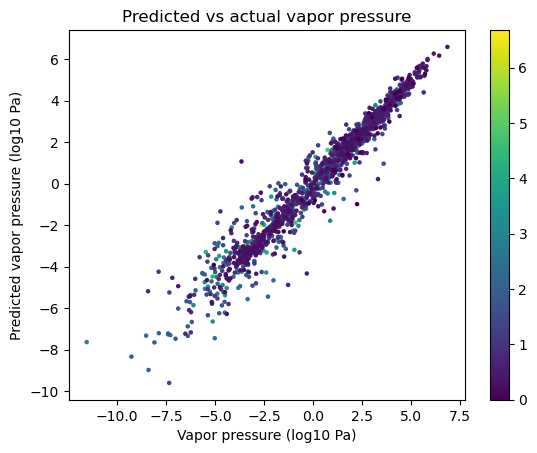

In [162]:
#scatter of pred vs ys, color gradient by log10nTABS
import numpy as np
plt.scatter(df_tabs_xgboost_physchem_not100['ys'], df_tabs_xgboost_physchem_not100['pred'], c=df_tabs_xgboost_physchem_not100['log10nTABS'],s=5)
plt.xlabel('Vapor pressure (log10 Pa)')
plt.ylabel('Predicted vapor pressure (log10 Pa)')
plt.title('Predicted vs actual vapor pressure')
plt.colorbar()
plt.show()



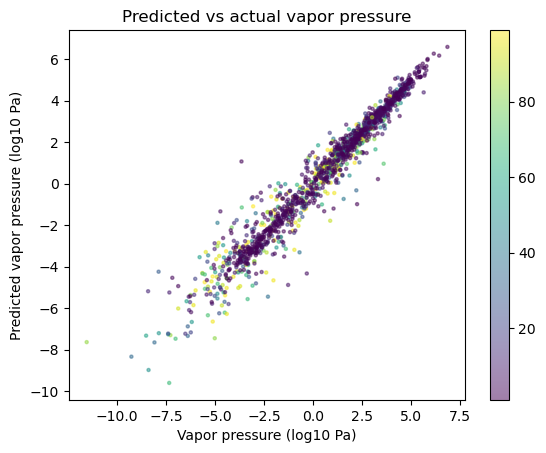

In [164]:
#same with confs generated
plt.scatter(df_tabs_xgboost_physchem_not100['ys'], df_tabs_xgboost_physchem_not100['pred'], c=df_tabs_xgboost_physchem_not100['confs_generated'],s=5,alpha=0.5)
plt.xlabel('Vapor pressure (log10 Pa)')
plt.ylabel('Predicted vapor pressure (log10 Pa)')
plt.title('Predicted vs actual vapor pressure')
plt.colorbar()
plt.show()


In [85]:
df_tabs_xgboost_physchem_not100['log10nTABS'] = np.log10(df_tabs_xgboost_physchem_not100['nTABS'])

/tmp/ipykernel_2723269/1685195410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tabs_xgboost_physchem_not100['log10nTABS'] = np.log10(df_tabs_xgboost_physchem_not100['nTABS'])


In [100]:
#take top 10%ntabs
top10_ntbas = df_tabs_xgboost_physchem['nTABS'].quantile(0.9)
df_tabs_xgboost_physchem['nrotatable_bonds'] = df_tabs_xgboost_physchem[['smiles']].apply(lambda x: rdMolDescriptors.CalcNumRotatableBonds(Chem.MolFromSmiles(x[0])), axis=1)
top10_nrbonds = df_tabs_xgboost_physchem['nrotatable_bonds'].quantile(0.9)
top10_nconfs = df_tabs_xgboost_physchem['confs_generated'].quantile(0.9)
#get overlaping molregnos
molregnos_ntabs = df_tabs_xgboost_physchem[df_tabs_xgboost_physchem['nTABS'] >= top10_ntbas]['molregno'].tolist()
molregnos_nrbonds = df_tabs_xgboost_physchem[df_tabs_xgboost_physchem['nrotatable_bonds'] >= top10_nrbonds]['molregno'].tolist()
molregnos_nconfs = df_tabs_xgboost_physchem[df_tabs_xgboost_physchem['confs_generated'] >= top10_nconfs]['molregno'].tolist()
#now get the overlap
most_flexible = list(set(molregnos_ntabs) & set(molregnos_nrbonds) & set(molregnos_nconfs))
print(len(most_flexible))
#same for bottom
bottom10_ntbas = df_tabs_xgboost_physchem['nTABS'].quantile(0.1)
bottom10_nrbonds = df_tabs_xgboost_physchem['nrotatable_bonds'].quantile(0.1)
bottom10_nconfs = df_tabs_xgboost_physchem['confs_generated'].quantile(0.1)
#get overlaping molregnos
molregnos_ntabs = df_tabs_xgboost_physchem[df_tabs_xgboost_physchem['nTABS'] <= bottom10_ntbas]['molregno'].tolist()
molregnos_nrbonds = df_tabs_xgboost_physchem[df_tabs_xgboost_physchem['nrotatable_bonds'] <= bottom10_nrbonds]['molregno'].tolist()
molregnos_nconfs = df_tabs_xgboost_physchem[df_tabs_xgboost_physchem['confs_generated'] <= bottom10_nconfs]['molregno'].tolist()
#now get the overlap
least_flexible = list(set(molregnos_ntabs) & set(molregnos_nrbonds) & set(molregnos_nconfs))
print(len(least_flexible))

/tmp/ipykernel_2723269/2913912881.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_tabs_xgboost_physchem['nrotatable_bonds'] = df_tabs_xgboost_physchem[['smiles']].apply(lambda x: rdMolDescriptors.CalcNumRotatableBonds(Chem.MolFromSmiles(x[0])), axis=1)


152
227


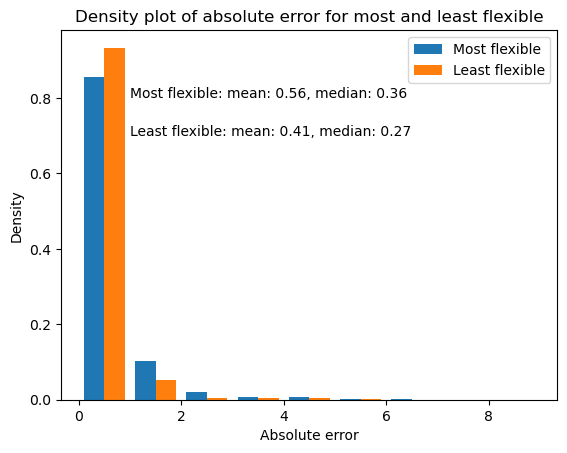

In [123]:
#get the preds and ys for these
df_xgboost_physchem_most_flexible = df_xgboost_physchem[df_xgboost_physchem['molregno'].isin(most_flexible)]
df_xgboost_physchem_least_flexible = df_xgboost_physchem[df_xgboost_physchem['molregno'].isin(least_flexible)]
#compare the errors
import seaborn as sns
plt.hist([df_xgboost_physchem_most_flexible['Absolute error'], df_xgboost_physchem_least_flexible['Absolute error']], bins=[x / 10 for x in range(0, 100,10)], density=True, label=['Most flexible', 'Least flexible'])
plt.legend()
plt.xlabel('Absolute error')
plt.ylabel('Density')
plt.title('Density plot of absolute error for most and least flexible')
#textbox with mean and median absolute error for both
mean_most_flexible = df_xgboost_physchem_most_flexible['Absolute error'].mean()
median_most_flexible = df_xgboost_physchem_most_flexible['Absolute error'].median()
mean_least_flexible = df_xgboost_physchem_least_flexible['Absolute error'].mean()
median_least_flexible = df_xgboost_physchem_least_flexible['Absolute error'].median()
plt.text(1, 0.8, f'Most flexible: mean: {mean_most_flexible:.2f}, median: {median_most_flexible:.2f}')
plt.text(1, 0.7, f'Least flexible: mean: {mean_least_flexible:.2f}, median: {median_least_flexible:.2f}')
plt.show()
#als

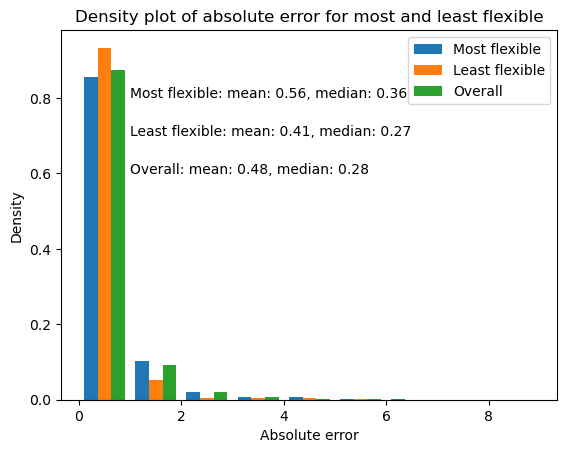

In [170]:
#same as before, but also add overall
plt.hist([df_xgboost_physchem_most_flexible['Absolute error'], df_xgboost_physchem_least_flexible['Absolute error'], df_xgboost_physchem['Absolute error']], bins=[x / 10 for x in range(0, 100,10)], density=True, label=['Most flexible', 'Least flexible', 'Overall'])
plt.legend()
plt.xlabel('Absolute error')
plt.ylabel('Density')
plt.title('Density plot of absolute error for most and least flexible')
#textbox with mean and median absolute error for both
mean_most_flexible = df_xgboost_physchem_most_flexible['Absolute error'].mean()
median_most_flexible = df_xgboost_physchem_most_flexible['Absolute error'].median()
mean_least_flexible = df_xgboost_physchem_least_flexible['Absolute error'].mean()
median_least_flexible = df_xgboost_physchem_least_flexible['Absolute error'].median()
mean_overall = df_xgboost_physchem['Absolute error'].mean()
median_overall = df_xgboost_physchem['Absolute error'].median()
plt.text(1, 0.8, f'Most flexible: mean: {mean_most_flexible:.2f}, median: {median_most_flexible:.2f}')
plt.text(1, 0.7, f'Least flexible: mean: {mean_least_flexible:.2f}, median: {median_least_flexible:.2f}')
plt.text(1, 0.6, f'Overall: mean: {mean_overall:.2f}, median: {median_overall:.2f}')
plt.show()

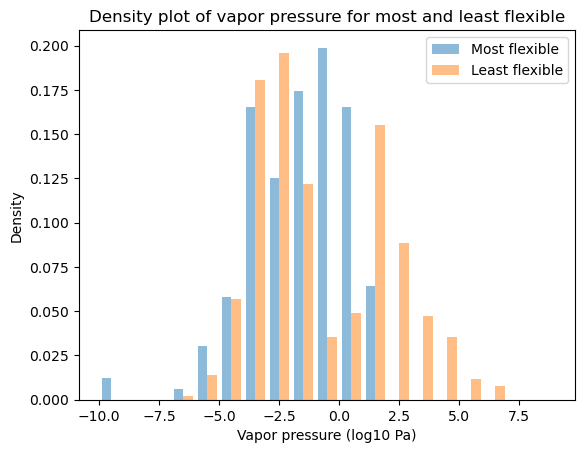

In [126]:
#also plot the vapor pressure for these
plt.hist([df_xgboost_physchem_most_flexible['ys'], df_xgboost_physchem_least_flexible['ys']], bins=[x / 10 for x in range(-100, 100,10)], density=True, alpha=0.5, label=['Most flexible', 'Least flexible'])
plt.legend()
plt.xlabel('Vapor pressure (log10 Pa)')
plt.ylabel('Density')
plt.title('Density plot of vapor pressure for most and least flexible')
#textbox with mean and median vapor pressure for both
mean_most_flexible = df_xgboost_physchem_most_flexible['ys'].mean()
median_most_flexible = df_xgboost_physchem_most_flexible['ys'].median()
mean_least_flexible = df_xgboost_physchem_least_flexible['ys'].mean()
median_least_flexible = df_xgboost_physchem_least_flexible['ys'].median()
# plt.text(-10, 0.01, f'Most flexible: mean: {mean_most_flexible:.2f}, median: {median_most_flexible:.2f}')
# plt.text(-10, 0.02, f'Least flexible: mean: {mean_least_flexible:.2f}, median: {median_least_flexible:.2f}')
plt.show()



In [158]:
df_xgboost_physchem

,molregno,pred,ys,confs_generated,Absolute error
0,3265,3.899125,3.857102,9,0.042024
1,2404,-3.187017,-0.962598,96,2.224419
2,766,0.105732,0.271002,1,0.165270
3,75,3.637582,3.931102,11,0.293521
4,656,-2.213919,-2.212298,100,0.001621
...,...,...,...,...,...
6035,3406,3.560667,3.500801,1,0.059866
6036,607,3.460873,3.487001,3,0.026128
6037,2811,3.809885,3.454202,9,0.355683
6038,765,-5.615860,-5.600899,92,0.014961


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


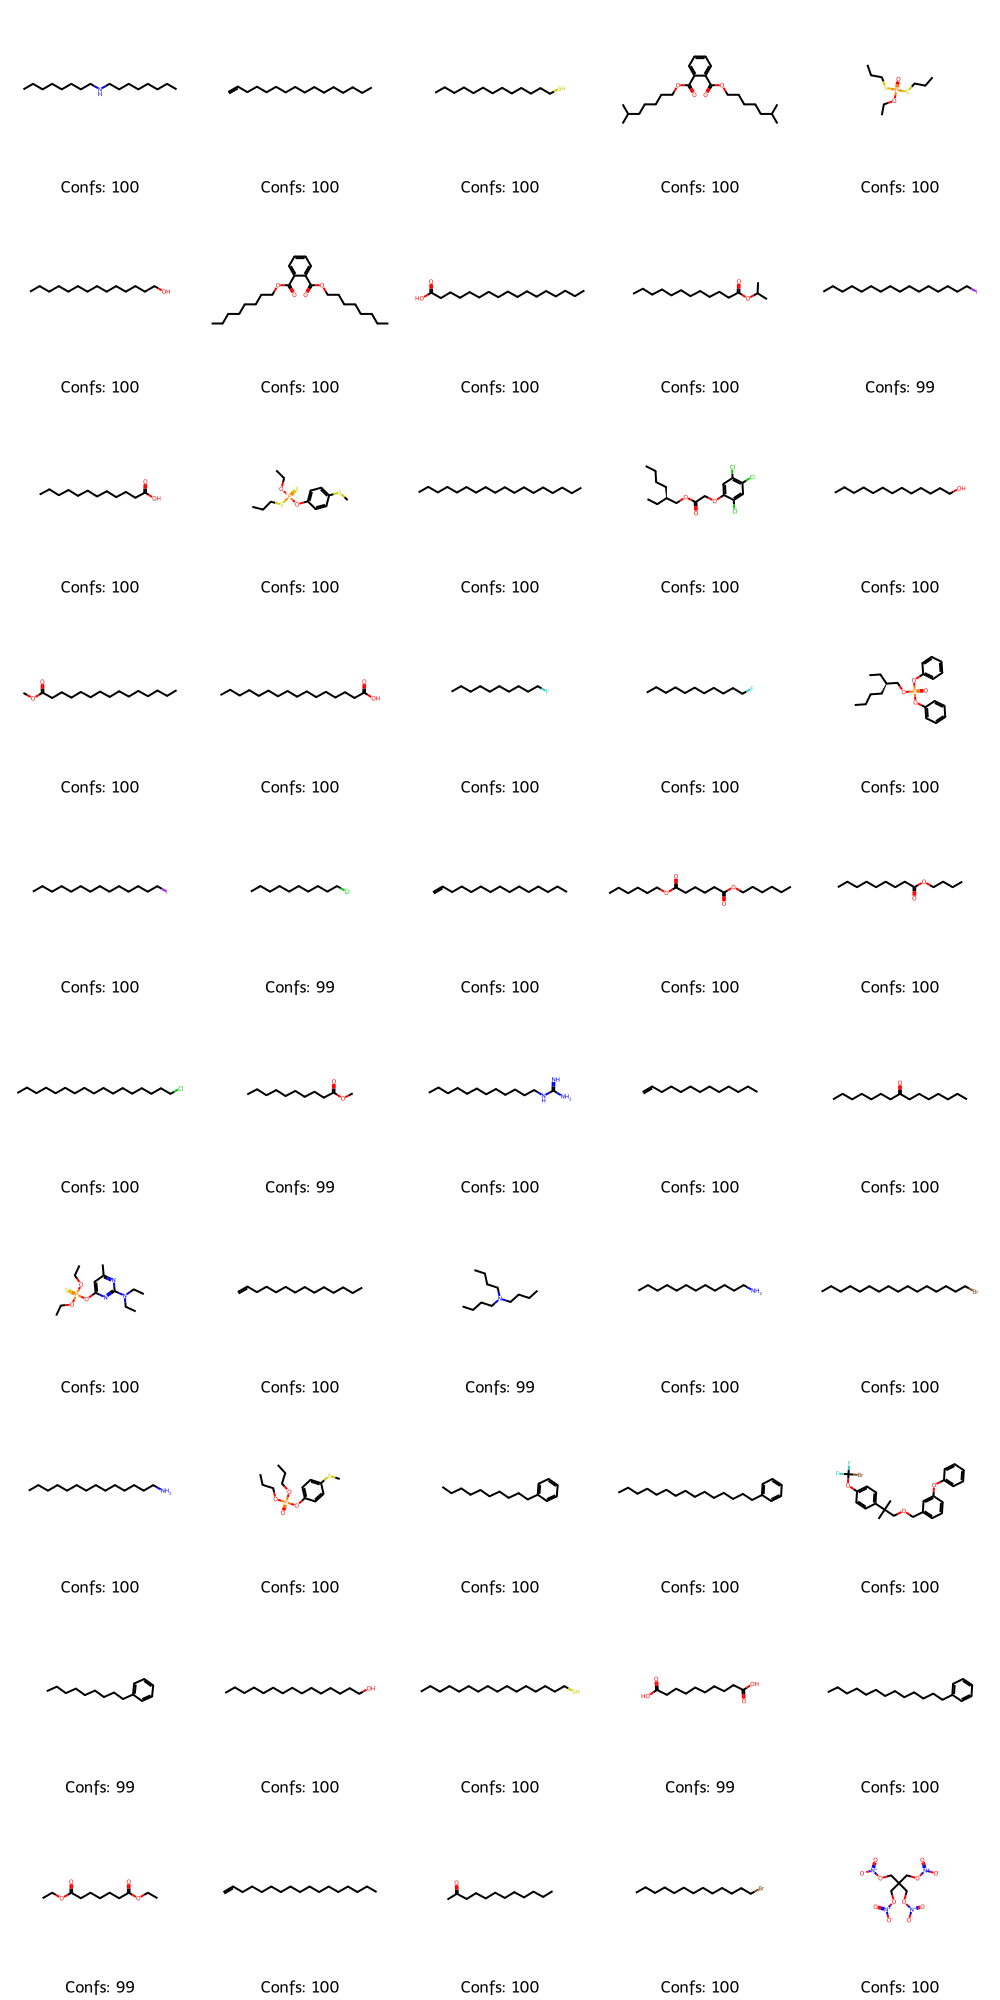

In [112]:
df_xgboost_physchem_most_flexible
#draw these
from rdkit.Chem import Draw
from rdkit import Chem
molregnos = df_xgboost_physchem_most_flexible['molregno'].tolist()
df = pd.read_csv('OPERA_Naef_Training_incl_num_confs.csv')
#get molblocks for these from df
df_most_flexible = df[df['molregno'].isin(molregnos)]
molblocks = df_most_flexible['molblock'].tolist()
num_confs_list = df_most_flexible['confs'].tolist()
mols = [Chem.MolFromMolBlock(mb) for mb in molblocks]
mols_2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in mols]
img = Draw.MolsToGridImage(mols_2d, molsPerRow=5, subImgSize=(200,200), legends=[f'Confs: {num_confs_list[i]}' for i in range(len(mols))])
img

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


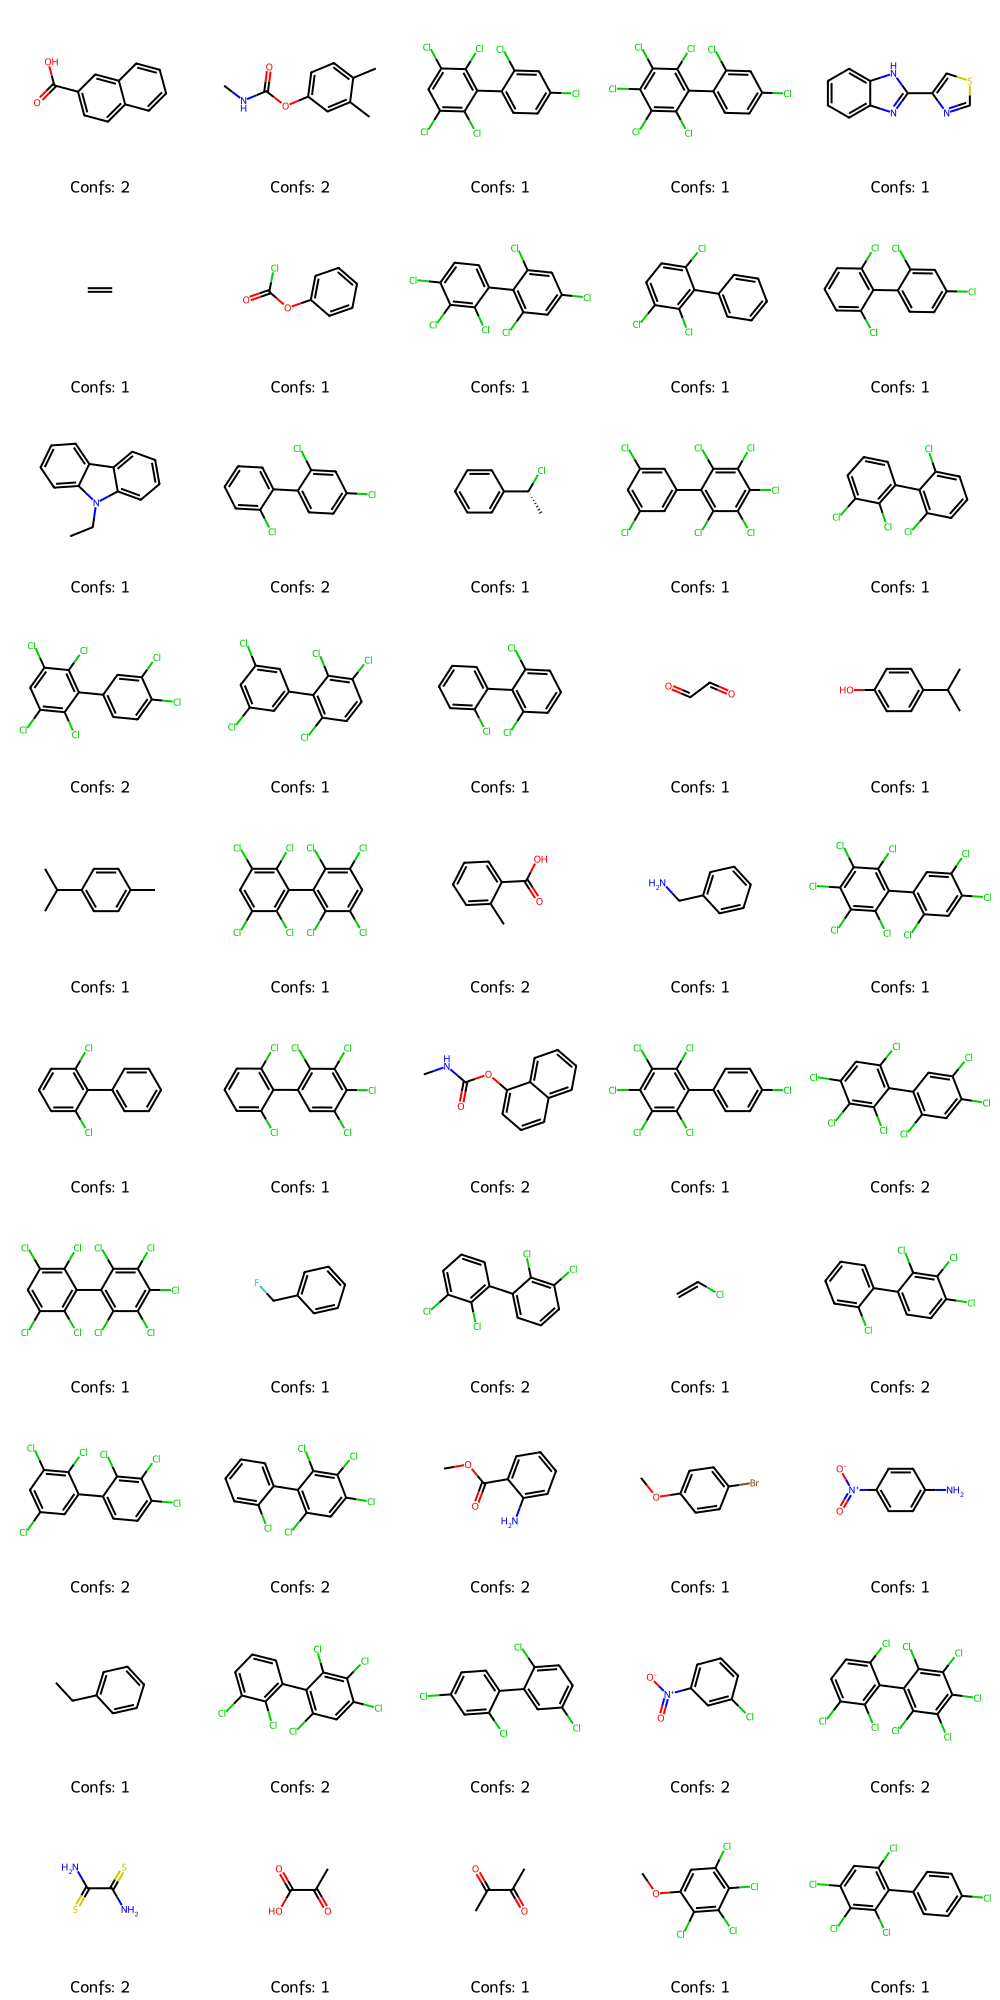

In [165]:
#same for least flexible
molregnos = df_xgboost_physchem_least_flexible['molregno'].tolist()
df = pd.read_csv('OPERA_Naef_Training_incl_num_confs.csv')
#get molblocks for these from df
df_least_flexible = df[df['molregno'].isin(molregnos)]
molblocks = df_least_flexible['molblock'].tolist()
num_confs_list = df_least_flexible['confs'].tolist()
mols = [Chem.MolFromMolBlock(mb) for mb in molblocks]
mols_2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in mols]
img = Draw.MolsToGridImage(mols_2d, molsPerRow=5, subImgSize=(200,200), legends=[f'Confs: {num_confs_list[i]}' for i in range(len(mols))])
img

Clc1ccc(-c2c(Cl)c(Cl)cc(Cl)c2Cl)c(Cl)c1
1


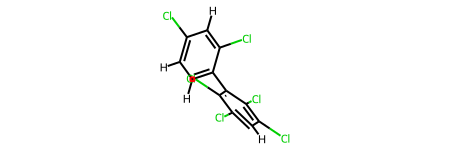

In [175]:
tests = Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(mols_2d[2])))
print(Chem.MolToSmiles(mols_2d[2]))
etkdg = rdDistGeom.ETKDGv3()
etkdg.randomSeed = 0xa700f
etkdg.verbose = False
etkdg.numThreads = 4
etkdg.trackFailures = True
etkdg.useRandomCoords = True
etkdg.pruneRmsThresh = 0.1
print(rdDistGeom.EmbedMultipleConfs(tests,numConfs = 100, params = etkdg))
print(tests.GetNumConformers())
tests



1


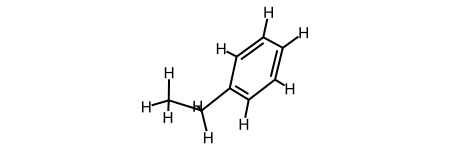

In [169]:
tests = Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(mols_2d[40])))
etkdg = rdDistGeom.ETKDGv3()
etkdg.randomSeed = 0xa700f
etkdg.verbose = False
etkdg.numThreads = 4
etkdg.trackFailures = True
etkdg.useRandomCoords = True
etkdg.pruneRmsThresh = 0.1
print(rdDistGeom.EmbedMultipleConfs(tests,numConfs = 100, params = etkdg))
print(tests.GetNumConformers())
tests



/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


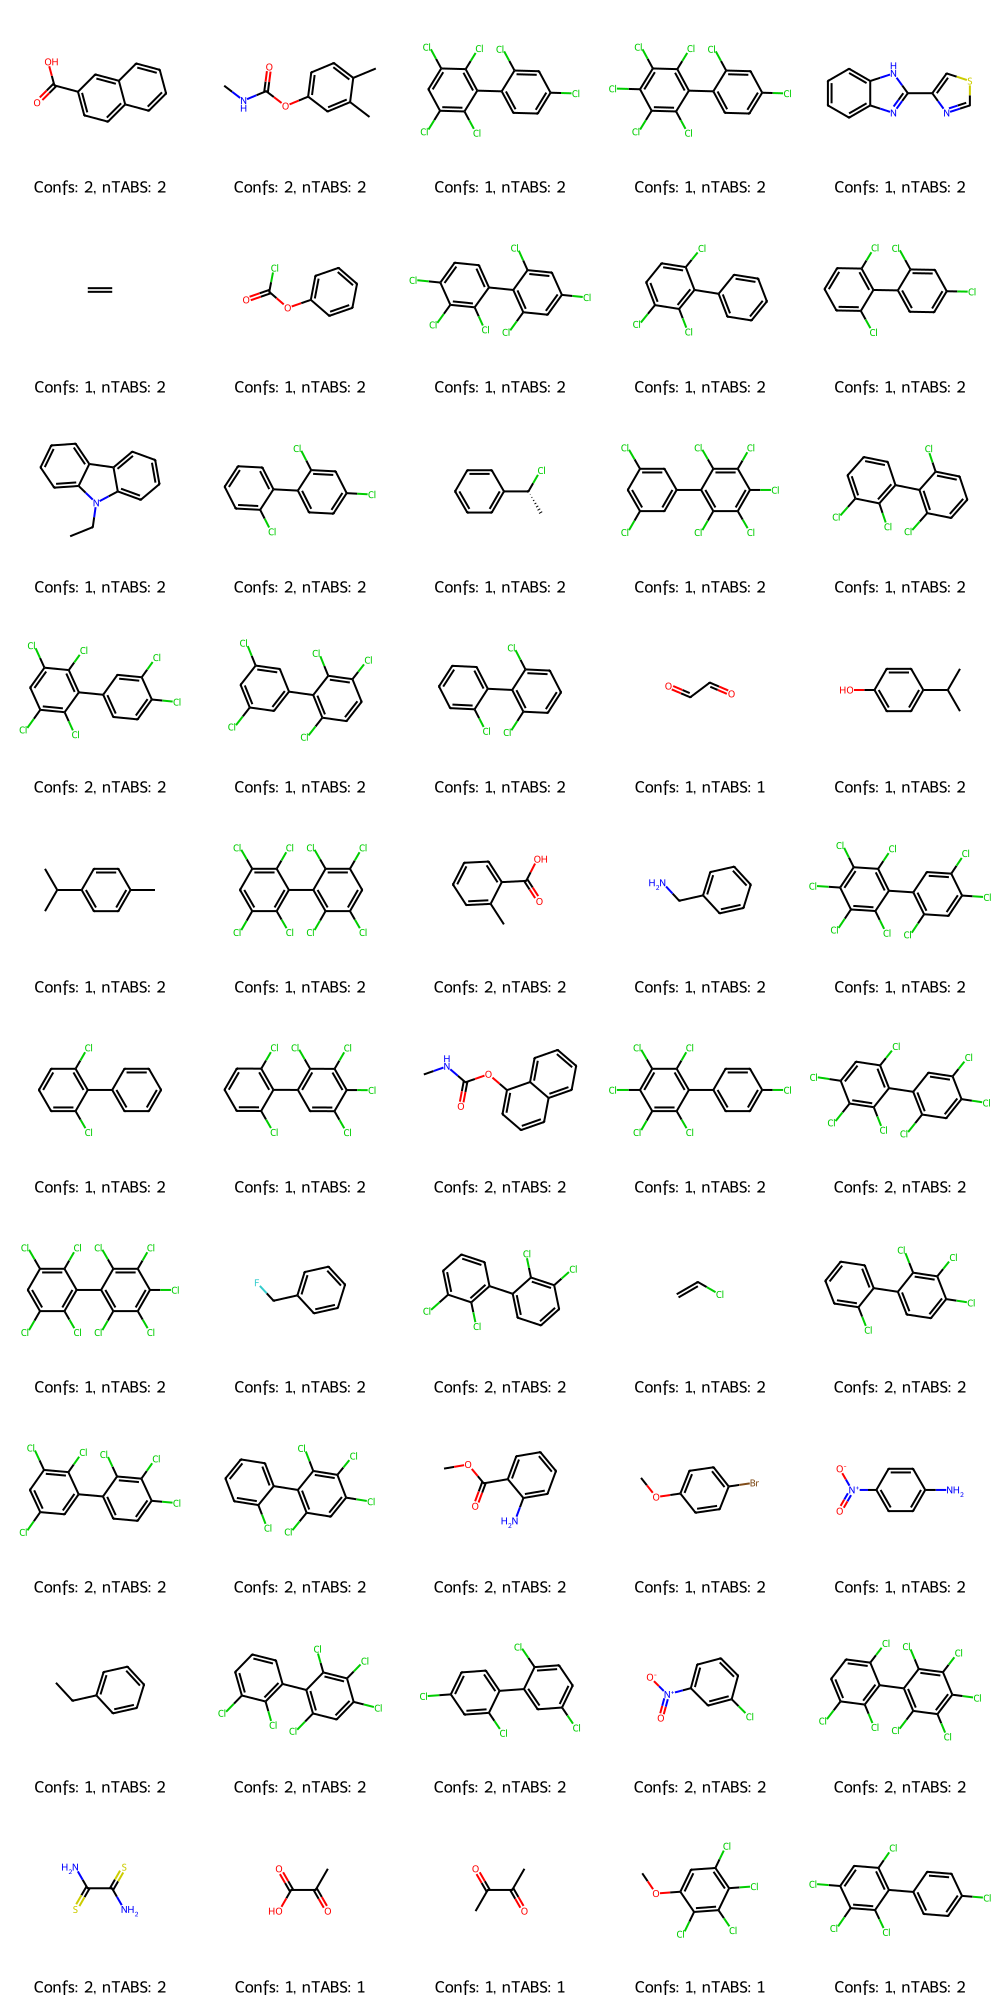

In [174]:
#get ntabs for these
#same for least flexible
molregnos = df_xgboost_physchem_least_flexible['molregno'].tolist()
df = pd.read_csv('OPERA_Naef_Training_incl_num_confs.csv')
#get molblocks for these from df
df_least_flexible = df[df['molregno'].isin(molregnos)]
molblocks = df_least_flexible['molblock'].tolist()
num_confs_list = df_least_flexible['confs'].tolist()
molregnos = df_least_flexible['molregno'].tolist()
#for these, get nTABS
ntabs_list = []
for molregno in molregnos:
    ntabs_list.append(df_tabs[df_tabs['molregno'] == molregno]['nTABS'].tolist()[0])
mols = [Chem.MolFromMolBlock(mb) for mb in molblocks]
mols_2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in mols]
img = Draw.MolsToGridImage(mols_2d, molsPerRow=5, subImgSize=(200,200), legends=[f'Confs: {num_confs_list[i]}, nTABS: {ntabs_list[i]}' for i in range(len(mols))])
img

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


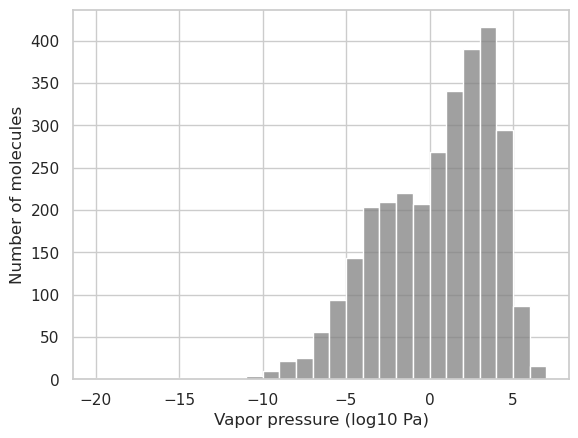

In [197]:
df = pd.read_csv('OPERA_Naef_Training.csv',)
#hist of vp_log10_pa using sns
import seaborn as sns
#make pretty
sns.set(style='whitegrid')
sns.histplot(df['vp_log10_pa'], bins=range(int(df['vp_log10_pa'].min())-1, int(df['vp_log10_pa'].max())+1, 1), color='grey')
plt.xlabel('Vapor pressure (log10 Pa)')
plt.ylabel('Number of molecules')
plt.xticks(range(-20, int(df['vp_log10_pa'].max())+1, 5))
plt.show()
